# ***Presentacion***

## **Tecnicatura Universitaria en Inteligencia Artificial**

### Trabájo Práctico - Minería de Datos

#### Arboles de descicion y aprendizaje supervizado

---

**equipo**:
- Revello Simon
- Giampaoli Fabio

**Fecha**: 10/11/2023

---

## ***Objetivo***



El objetivo de este trabajo practico es integrar los conocimientos adquiridos en las unidades 4 y 5
en dos problemas reales asociados uno al comportamiento financiero de 1000 empresas y otro a
un juego de cartas,

# ***Entorno***

## Librerias

In [34]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import widgets, interact
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

## Datasets

In [35]:
cartas = pd.read_csv('PokemonDB.csv')
companies = pd.read_csv('1000_Companies.csv')

In [36]:
cartas

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...
1185,Chi-Yu,Dark,55,80,80,135,120,100
1186,Roaring Moon,Dragon,105,139,71,55,101,119
1187,Iron Valiant,Fairy,74,130,90,120,60,116
1188,Koraidon,Fighting,100,135,115,85,100,135


In [37]:
companies

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


# ***Ejercicios***

## **Primer ejercicio**

---

Descargar el conjunto de datos, 1000_Companies.csv1, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.) y elegir un método de estandarización

---

### Section

In [38]:
companies.shape

(1000, 5)

In [39]:
companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [40]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


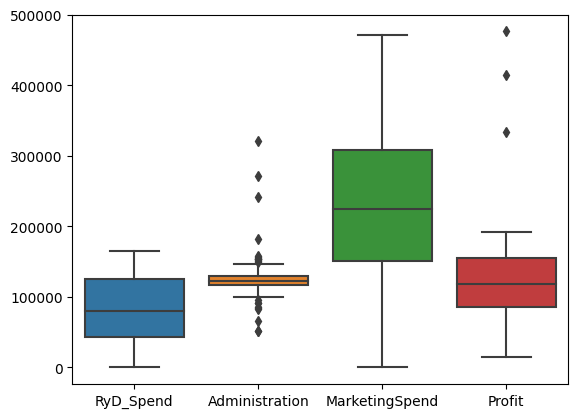

(<Axes: >, None)

In [41]:
sns.boxplot(companies), plt.show()

### Section

In [42]:

def create_plots(df, explanatory_var, binary_var='State'):
    fig, axs = plt.subplots(3, 1, figsize=(6,6))

    # es un grafico de una sola dimension que le da grosor en el eje y solo por facilidad de visualizacion, separa las clases en colores
    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=binary_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + binary_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    # crea distribucion en boxplot de la variable separado por clase
    sns.boxplot(y=binary_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    # distribuciones de densidad por clases
    sns.kdeplot(data=df, x=explanatory_var, hue=binary_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

# Crear selector de variable explicativa
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in companies.columns if col not in ['State']],
    description='Explicativa:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_plots, df=widgets.fixed(companies), explanatory_var=explanatory_var_widget)

interactive(children=(Dropdown(description='Explicativa:', options=('RyD_Spend', 'Administration', 'MarketingS…

<function __main__.create_plots(df, explanatory_var, binary_var='State')>

### Section

In [43]:
# Crear un diccionario de colores
color_dict = {
    'RyD_Spend': '#D18CE0',
    'Administration': '#FF5733',
    'MarketingSpend': '#C70039',
    'State': '#900C3F',
    'Profit': '#581845'
}

def create_plots(df, variable):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Boxplot
    bp = ax.boxplot(df[variable], patch_artist=True, vert=False)
    bp['boxes'][0].set_facecolor(color_dict[variable])
    bp['boxes'][0].set_alpha(0.7)

    # Violin plot
    vp = ax.violinplot(df[variable], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(color_dict[variable])
    vp['bodies'][0].set_alpha(0.7)

    # Scatter plot
    y = np.full(len(df[variable]), 0.8) + np.random.uniform(low=-.1, high=.1, size=len(df[variable]))
    ax.scatter(df[variable], y, s=3, c=color_dict[variable])

    # Configurar títulos y etiquetas
    ax.set_title(variable)
    ax.set_yticks([])
    ax.set_xlabel("Value")

    plt.show()

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in companies.columns],
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_plots, df=widgets.fixed(companies), variable=variable_widget)


interactive(children=(Dropdown(description='Variable:', options=('RyD_Spend', 'Administration', 'MarketingSpen…

<function __main__.create_plots(df, variable)>

### Section

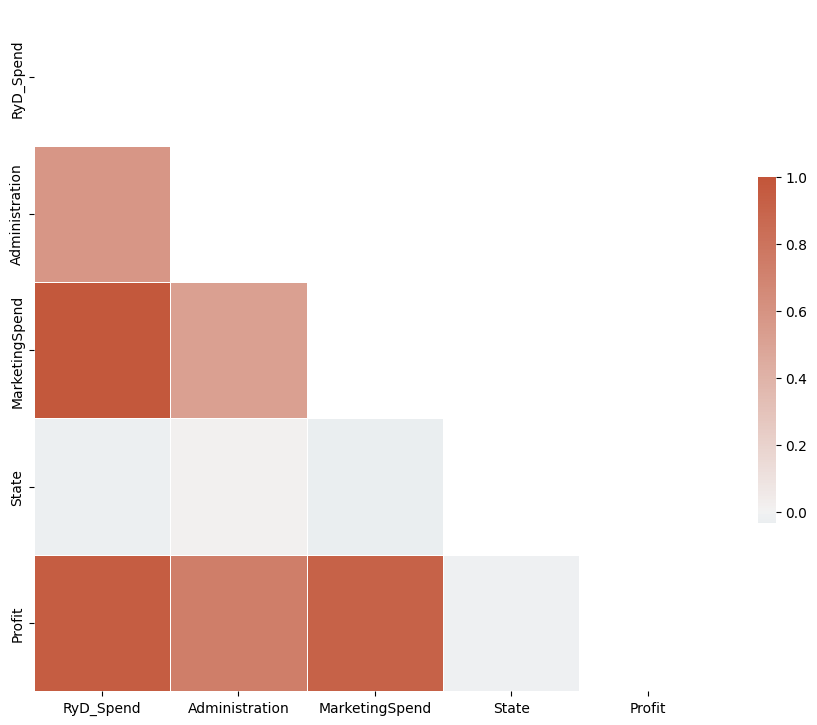

In [44]:
def grafico_correlacion(df):
    # Hacer un encoding de frecuencia para la variable categórica
    encoding = df.groupby('State').size()
    encoding = encoding / len(df)
    df['State'] = df['State'].map(encoding)

    # Calcular la matriz de correlación
    corr = df.corr()

    # Crear una máscara para el triángulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Configurar la figura de matplotlib
    fig, ax = plt.subplots(figsize=(11, 9))

    # Generar un mapa de colores divergentes personalizado
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso de la función con el dataframe companies y la variable 'state'
grafico_correlacion(companies)


### Section

In [45]:
def estandarize(df):
  data = df.copy()
  scaler = StandardScaler()

  data_scaled = scaler.fit_transform(data)
  data_standardized = pd.DataFrame(data_scaled, columns=data.columns)

  return data_standardized, scaler #retorno el scaler entrenado para luego desnormalizar las variables si lo necesitara.

def normalize(df):
  data = df.copy()
  scaler = MinMaxScaler()

  data_scaled = scaler.fit_transform(data)
  data_standardized = pd.DataFrame(data_scaled, columns=data.columns)

  return data_standardized, scaler

def robustize(df):
  data = df.copy()
  scaler = RobustScaler()

  data_scaled = scaler.fit_transform(data)
  data_standardized = pd.DataFrame(data_scaled, columns=data.columns)

  return data_standardized, scaler

In [46]:
# Crear un diccionario de funciones de estandarización
standardize_dict = {
    'Estandar': estandarize,
    'MinMax': normalize,
    'Robust': robustize
}

def show_distributions(df, method):
    df_standardized, _ = standardize_dict[method](df)
    plt.figure(figsize=(8, 4))
    sns.boxplot(df_standardized)
    plt.xticks(rotation=90)
    plt.show()

# Crear selector de método de estandarización
method_widget = widgets.Dropdown(
    options=[method for method in standardize_dict.keys()],
    description='Método:',
)

# Usar interact para crear la actualizar el gráfico en un cambio
interact(show_distributions, df=widgets.fixed(companies), method=method_widget)


interactive(children=(Dropdown(description='Método:', options=('Estandar', 'MinMax', 'Robust'), value='Estanda…

<function __main__.show_distributions(df, method)>

In [47]:
df_standar, standar_scaler = estandarize(companies)
df_standar.head(2)

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,1.799023,1.105197,2.682968,0.047231,1.696301
1,1.739869,2.253692,2.378316,1.161177,1.685343


## **Segundo ejercicio**

---

Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Error Absoluto Medio, Error Cuadrático Medio y Raíz del Error
Cuadrático Medio)

---

### Section

IntSlider(value=1, description='Max Depth:', max=20, min=1)

IntSlider(value=2, description='Min Split:', max=50, min=2)

IntSlider(value=1, description='Min Leaf:', max=50, min=1)

Dropdown(description='Criterion:', options=('squared_error', 'friedman_mse', 'absolute_error'), value='squared…

Button(description='Estimar Profit', style=ButtonStyle())

Output()

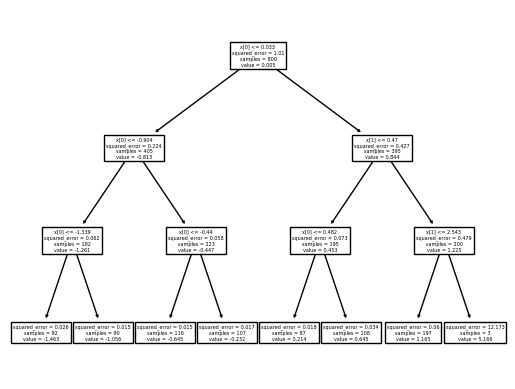

In [54]:

# Crear los widgets para los parámetros
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1, description='Max Depth:')
min_samples_split_widget = widgets.IntSlider(min=2, max=50, step=1, description='Min Split:')
min_samples_leaf_widget = widgets.IntSlider(min=1, max=50, step=1, description='Min Leaf:')
criterion_widget = widgets.Dropdown(options=['squared_error', 'friedman_mse', 'absolute_error'], description='Criterion:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Profit")
# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(df_standar.drop('Profit', axis=1), df_standar['Profit'], test_size=0.2, random_state=42)

    # Crear y entrenar el modelo
    model = DecisionTreeRegressor(max_depth=max_depth_widget.value,
                                  min_samples_split=min_samples_split_widget.value,
                                  min_samples_leaf=min_samples_leaf_widget.value,
                                  criterion=criterion_widget.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Mostrar los resultados en el contenedor de salida
    with out:

        print(f'Error Absoluto Medio: {mae}')
        print(f'Error Cuadrático Medio: {mse}')
        print(f'Raíz del Error Cuadrático Medio: {rmse}')
        print(f'R^2: {r2}')

        plot_tree(model)


# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(max_depth_widget, min_samples_split_widget, min_samples_leaf_widget, criterion_widget, button, out)



### Section

### Section

## **Tercer ejercicio**

---

Descargar el conjunto de datos, PokemonDB.csv2, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.)

---

### Section

### Section

## **Cuarto ejercicio**

---

Realizar la estimación del atributo Type utilizando árboles de decisión (Clasificación)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Section

### Section

## **Quinto ejercicio**

---

Realizar la estimación del atributo Type utilizando Bayes Ingenuo. Aquí deberá
considerar un criterio de división de los atributos para discretizarlos. Mostrar los
resultados sobre dos conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Section

### Section

## **Sexto ejercicio**

---

Realizar la estimación del atributo Type utilizando k-NN analizando los parámetros
cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre un conjunto de
test (Precisión, Exhaustividad y Exactitud)

---

### Section

### Section

# ***Conclusiones***